In [ ]:
#Import necessary library case uts
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Math

In [ ]:
def potential(xmin, xmax, noise, xpow):
  '''
  Set harmonic oscillator potential within the system
  Input   : x interval, noise, x power
  Return  : potential
  '''

  #Harmonic Oscillator Potential V = 1/2*k*x**2 + lambda*x**xpow for k = 1 and xpow = [1, 2, 3, 4]
  potential_v = (1/2 * xmin * xmin) + (noise*xmin**xpow)

  return potential_v

In [ ]:
def normalize(n, h, psi):
  '''
  Normalize wave function
  Input   : initial wave function, number of points, step
  Return  : normalized wave function
  '''
  norm = psi[0]**2+psi[n]**2
  for i in range(1,n-3,2):
    norm = norm+4*psi[i]**2+2*psi[i+1]**2

  norm = norm + 4*psi[n-1]**2
  norm = 1/np.sqrt((norm*h/3))

  for i in range(0, len(psi)):
   psi[i] = psi[i]*norm

  return psi

In [ ]:
def numerov(nx, x, e_init, psi, noise, xpow):
  '''
  Integrates the wave function using Numerov's method
  Input   : number of points, x inteval, initial energy, wave function
  Return  : integrated wave function
  '''

  #Calculates the steps
  h = xmax/nx
  h2 = h**2
  h12 = h2/12

  #Initialize wave function
  psi[0] = 0
  psi[1] = 0.0001

  #Calculates using Numerov's nethod
  fn = 2*(potential(-x, x, noise, xpow)-e_init)
  q0 = psi[0]*(1-h12*fn)
  fn = 2*(potential(-x+h, x, noise, xpow)-e_init)
  q1 = psi[1]*(1-h12*fn)
  
  for n in range(2, 2*nx+1):
    q2 = h2*fn*psi[n-1]+2*q1-q0
    fn = 2*(potential(n*h-x, x, noise, xpow)-e_init)
    psi[n] = q2/(1-h12*fn)
    q0 = q1
    q1 = q2

  psi = normalize(2*nx, h, psi)

  return psi

In [ ]:
def calculates(nx, x, e_init, de, eps, psi, noise, xpow):
  '''
  Starting course search and approximate energy level using bisection method
  Input   : number of points, x inteval, initial energy,
            eps, lists to store energy and deviation
  Return  : Energy approximation, wave function
  '''
  #Starting course search
  psi = numerov(nx, x, e_init, psi, noise, xpow)
  dev1 = psi[2*nx]

  while True:
    #Update energy with de step
    e2 = e_init + de
 
    psi = numerov(nx, x, e2, psi, noise, xpow)
    dev2 = psi[2*nx]

    #Check if deviation is zero
    if dev1*dev2 < 0:
      break

    #Update energy and deviation value for next iteration  
    e_init = e2
    dev1 = dev2

  #Starting bisection
  while abs(e_init-e2) > eps:
    e3 = (e_init+e2)/2
    psi = numerov(nx,x,e3,psi, noise, xpow)
    dev3 = psi[2*nx]

    if dev3*dev1 <= 0.000000 :
      e2 = e3
      dev2 = dev3
    else:
      e_init = e3
      dev2 = dev3

  return e3, psi

In [ ]:
def schrod(nx, xmax, e0, de, filename, n, noise, xpow):
  '''
  Function to calculates energy and wave function
  Input   : number of points, x interval, initial energy, delta e, filename, energy level
  Return  : approximated energy, psi .date file
  '''
  #Initialize Parameters
  eps = 10e-6
  dx = xmax/nx

  #Initialize wave function
  psi = np.zeros(2*nx+1)

  #Calculates energy and deviation
  energy, psi = calculates(nx, xmax, e0, de, eps, psi, noise, xpow)

  #Save output as dat file
  filename = filename + str(n) + '.dat'
  x = np.zeros(2*nx+1)
  for i in range(1, 2*nx+2):
    x[i-1] = (i-1)*dx-xmax
    
  with open(filename, 'w') as out_file:
    for item in range(len(psi)):
      # out_file.write(str(x[item]) + '      ' + (psi[item]) + '\n')
      out_file.write("{}      {}      \n".format(x[item], psi[item]))

  return energy

In [ ]:
def analytics(e_init, noise, n, xpow):
  '''
  Calculates analytics value
  Input   : energy, noise, energy level, x power
  Return  : final energy
  '''

  energy_add = 0
  m = 1
  omega = 1
  hbar = 1
  #Check x power
  if xpow == 0:
    energy_add = noise
  elif xpow == 1:
    energy_add = -(noise**2)/(2*m*omega**2)
  elif xpow == 2:
    energy_add = e_init*(noise/4 - (noise**2)/32)
  elif xpow == 3:
    energy_add = (-(15*noise**2 * hbar**2)/(4*m**3 * omega**4))*(n**2 - n + (11/30))
  elif xpow == 4:
    energy_add = ((3*noise*hbar**2)/(4*m**2 * omega**2))*(2*n**2 + 2*n + 1)
  else:
    energy_add = 0

  final_energy = e_init + energy_add

  return final_energy


In [ ]:
#Initialize Parameters
nx = 100
xmax = 6 #L = 4
de = 0.001
energy_level = [i for i in range(0, 11)]
xpower = [i for i in range(0, 5)]
noise = 0.01
columns = ['Energy Level', 'Energy (a.u.)', 'Analytics', 'Error']

#Create dataframe to store output
output0 = pd.DataFrame(columns=columns)
output1 = pd.DataFrame(columns=columns)
output2 = pd.DataFrame(columns=columns)
output3 = pd.DataFrame(columns=columns)
output4 = pd.DataFrame(columns=columns)

for n in xpower:
  e0 = 0
  energy_value = []
  analytic_value = []
  filename = 'psi-out'+str(n)

  for i in energy_level:
    energy = schrod(nx, xmax, e0, de, filename, i, noise, n)
    energy_value.append(energy)

    #Update for the next energy level
    e0 = energy + 0.005

  for j in energy_level:
    e_init = j + 0.5
    energy_ana = analytics(e_init, noise, j, n)
    analytic_value.append(energy_ana)

  if n == 0:
    for i in range(len(energy_level)):
      output0.loc[i] = [energy_level[i], energy_value[i], analytic_value[i], abs(analytic_value[i]-energy_value[i])]
  
  if n == 1:
    for i in range(len(energy_level)):
      output1.loc[i] = [energy_level[i], energy_value[i], analytic_value[i], abs(analytic_value[i]-energy_value[i])]

  if n == 2:
    for i in range(len(energy_level)):
      output2.loc[i] = [energy_level[i], energy_value[i], analytic_value[i], abs(analytic_value[i]-energy_value[i])]

  if n == 3:
    for i in range(len(energy_level)):
      output3.loc[i] = [energy_level[i], energy_value[i], analytic_value[i], abs(analytic_value[i]-energy_value[i])]

  if n == 4:
    for i in range(len(energy_level)):
      output4.loc[i] = [energy_level[i], energy_value[i], analytic_value[i], abs(analytic_value[i]-energy_value[i])]

In [ ]:
display(Math('V_g = \lambda'))
output0

<IPython.core.display.Math object>

,Energy Level,Energy (a.u.),Analytics,Error
0,0.0,0.509992,0.51,7.812500e-06
1,1.0,1.510000,1.51,5.528911e-14
2,2.0,2.509992,2.51,7.812500e-06
3,3.0,3.510000,3.51,2.744471e-13
4,4.0,4.509992,4.51,7.812500e-06
5,5.0,5.509984,5.51,1.562500e-05
6,6.0,6.509977,6.51,2.343750e-05
7,7.0,7.509969,7.51,3.125000e-05
8,8.0,8.509961,8.51,3.906250e-05
9,9.0,9.509984,9.51,1.562500e-05


In [ ]:
display(Math('V_g = \lambda x'))
output1

<IPython.core.display.Math object>

,Energy Level,Energy (a.u.),Analytics,Error
0,0.0,0.499945,0.49995,0.000005
1,1.0,1.499953,1.49995,0.000003
2,2.0,2.499945,2.49995,0.000005
3,3.0,3.499953,3.49995,0.000003
4,4.0,4.499945,4.49995,0.000005
5,5.0,5.499938,5.49995,0.000012
6,6.0,6.499930,6.49995,0.000020
7,7.0,7.499922,7.49995,0.000028
8,8.0,8.499914,8.49995,0.000036
9,9.0,9.499938,9.49995,0.000012


In [ ]:
display(Math('V_g = \lambda x^2'))
output2

<IPython.core.display.Math object>

,Energy Level,Energy (a.u.),Analytics,Error
0,0.0,0.504977,0.501248,0.003728
1,1.0,1.514922,1.503745,0.011177
2,2.0,2.524867,2.506242,0.018625
3,3.0,3.534828,3.508739,0.026089
4,4.0,4.544773,4.511236,0.033537
5,5.0,5.554719,5.513733,0.040986
6,6.0,6.564664,6.516230,0.048434
7,7.0,7.574594,7.518727,0.055867
8,8.0,8.584539,8.521223,0.063316
9,9.0,9.594516,9.523720,0.070795


In [ ]:
display(Math('V_g = \lambda x^3'))
output3

<IPython.core.display.Math object>

,Energy Level,Energy (a.u.),Analytics,Error
0,0.0,0.499867,0.499862,0.000005
1,1.0,1.499109,1.499863,0.000753
2,2.0,2.497602,2.499112,0.001511
3,3.0,3.495344,3.497612,0.002269
4,4.0,4.492320,4.495362,0.003042
5,5.0,5.488531,5.492362,0.003831
6,6.0,6.483977,6.488613,0.004636
7,7.0,7.478656,7.484113,0.005456
8,8.0,8.472570,8.478862,0.006292
9,9.0,9.465859,9.472862,0.007003


In [ ]:
display(Math('V_g = \lambda x^4'))
output4

<IPython.core.display.Math object>

,Energy Level,Energy (a.u.),Analytics,Error
0,0.0,0.507258,0.5075,0.000242
1,1.0,1.535641,1.5375,0.001859
2,2.0,2.590852,2.5975,0.006648
3,3.0,3.671094,3.6875,0.016406
4,4.0,4.774898,4.8075,0.032602
5,5.0,5.901016,5.9575,0.056484
6,6.0,7.048305,7.1375,0.089195
7,7.0,8.215797,8.3475,0.131703
8,8.0,9.402633,9.5875,0.184867
9,9.0,10.608016,10.8575,0.249484


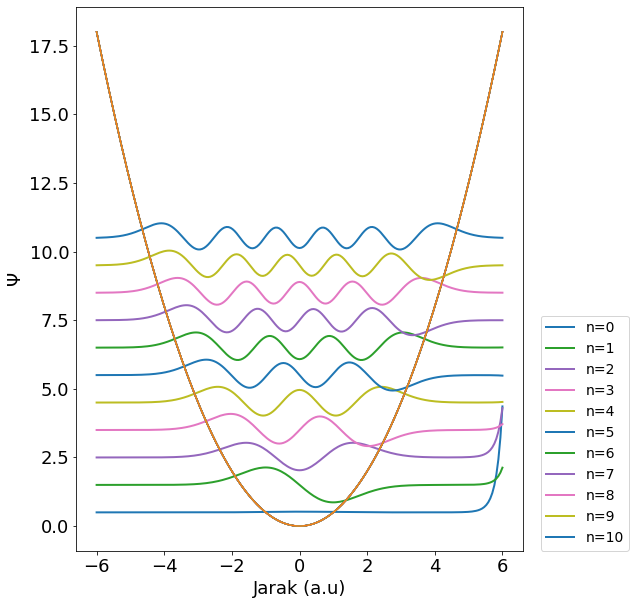

In [ ]:
#Plot wave function

filename = 'psi-out0'

fig, ax = plt.subplots(figsize=(8, 10))

for n in range(0, 11):
  data = np.loadtxt(filename+str(n)+'.dat', unpack=True)
  x_pos = data[0]
  psii = data[1]

  plt.plot(x_pos, psii + (n+0.5), label='n='+str(n), linewidth=2)
  plt.plot(x_pos, 1/2*x_pos*x_pos)

plt.xlabel('Jarak (a.u)', fontsize=18)
plt.ylabel('$\Psi$', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(bbox_to_anchor=(1.04,0), loc="lower left", borderaxespad=0, fontsize=14)
plt.show()

In [ ]:
  
filename = 'psi-out00'
data = np.loadtxt(filename+'.dat', unpack=True)
x_pos = data[0]
psii = data[1]

x_pos
psii


array([0.00000000e+00, 2.78650097e-10, 5.91921619e-10, 9.77317384e-10,
       1.47933598e-09, 2.15414736e-09, 3.07516499e-09, 4.34000446e-09,
       6.07939254e-09, 8.46870405e-09, 1.17429600e-08, 1.62163214e-08,
       2.23073697e-08, 3.05717770e-08, 4.17443600e-08, 5.67929739e-08,
       7.69872689e-08, 1.03985996e-07, 1.39947340e-07, 1.87667676e-07,
       2.50755223e-07, 3.33846272e-07, 4.42873102e-07, 5.85394200e-07,
       7.70999202e-07, 1.01180281e-06, 1.32304401e-06, 1.72380913e-06,
       2.23789932e-06, 2.89486559e-06, 3.73123635e-06, 4.79196476e-06,
       6.13212466e-06, 7.81888528e-06, 9.93379552e-06, 1.25754086e-05,
       1.58622761e-05, 1.99363397e-05, 2.49667414e-05, 3.11540722e-05,
       3.87350664e-05, 4.79877415e-05, 5.92369711e-05, 7.28604593e-05,
       8.92950726e-05, 1.09043458e-04, 1.32680857e-04, 1.60861996e-04,
       1.94327907e-04, 2.33912499e-04, 2.80548674e-04, 3.35273748e-04,
       3.99233904e-04, 4.73687387e-04, 5.60006110e-04, 6.59675340e-04,
      

In [ ]:
filename = 'psi-out00'
data = np.loadtxt(filename+'.dat', unpack=True)
x_pos = data[0]
psii = data[1]

x_pos
psii

array([0.00000000e+00, 2.78650097e-10, 5.91921619e-10, 9.77317384e-10,
       1.47933598e-09, 2.15414736e-09, 3.07516499e-09, 4.34000446e-09,
       6.07939254e-09, 8.46870405e-09, 1.17429600e-08, 1.62163214e-08,
       2.23073697e-08, 3.05717770e-08, 4.17443600e-08, 5.67929739e-08,
       7.69872689e-08, 1.03985996e-07, 1.39947340e-07, 1.87667676e-07,
       2.50755223e-07, 3.33846272e-07, 4.42873102e-07, 5.85394200e-07,
       7.70999202e-07, 1.01180281e-06, 1.32304401e-06, 1.72380913e-06,
       2.23789932e-06, 2.89486559e-06, 3.73123635e-06, 4.79196476e-06,
       6.13212466e-06, 7.81888528e-06, 9.93379552e-06, 1.25754086e-05,
       1.58622761e-05, 1.99363397e-05, 2.49667414e-05, 3.11540722e-05,
       3.87350664e-05, 4.79877415e-05, 5.92369711e-05, 7.28604593e-05,
       8.92950726e-05, 1.09043458e-04, 1.32680857e-04, 1.60861996e-04,
       1.94327907e-04, 2.33912499e-04, 2.80548674e-04, 3.35273748e-04,
       3.99233904e-04, 4.73687387e-04, 5.60006110e-04, 6.59675340e-04,
      

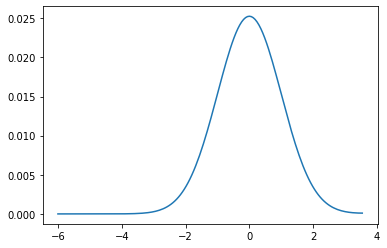

In [ ]:
plt.plot(x_pos[:160], psii[:160])

plt.show()